In [1]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!pip install split-folders
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 33.4 MB/s eta 0:00:00


In [3]:
import splitfolders 
import visualkeras
splitfolders.ratio("/kaggle/input/agronify-dataset/DiseasedPlants/DiseasedPlants/Perkebunan/Kentang", 
                   output="Kentang-data", 
                   seed=42, 
                   ratio=(.8, .1, .1), 
                   group_prefix=None) 

Copying files: 2341 files [00:14, 165.72 files/s]


In [4]:
training_dir = os.path.join('Kentang-data', 'train')
testing_dir = os.path.join('Kentang-data', 'test')
validating_dir = os.path.join('Kentang-data', 'val')

In [5]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 1871 images belonging to 3 classes.
Found 233 images belonging to 3 classes.
Found 237 images belonging to 3 classes.


In [6]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Potato__early_blight': 0, 'Potato__healthy': 1, 'Potato__late_blight': 2}
['Potato__early_blight', 'Potato__healthy', 'Potato__late_blight']


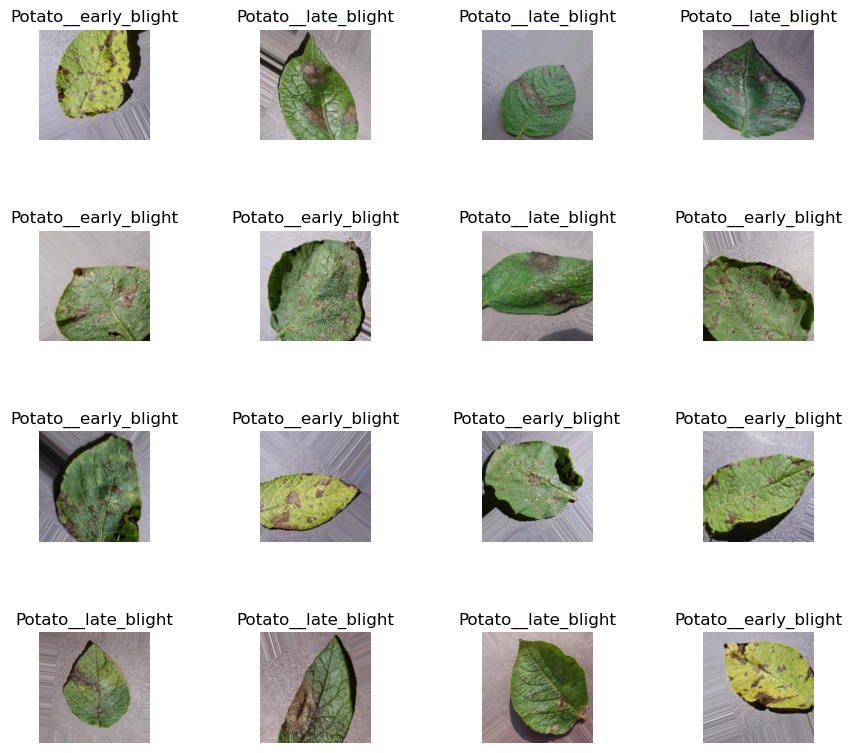

In [7]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nDo you want to continue training (Y/N)?')
                ans = input()

                if ans.lower() == 'n':
                    print('Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += 1

In [49]:
tf.keras.backend.clear_session()
#del model

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

IMAGE_CHANNEL = 3
IMAGE_SIZE = 224
OUTPUT_SIZE = len(class_names)

inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL))

x = Conv2D(512, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(3, 3))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)


x = Flatten()(x)

x = Dense(8, activation='relu')(x)
x = Dense(OUTPUT_SIZE, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 512)     14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       295040

In [ ]:
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# image_shape = (224, 224, 3)
# model_name = 'MobileNet'
# base_model = MobileNet(
#     include_top=False,
#     input_shape=image_shape,
#     pooling=None,  # Remove the pooling parameter
#     weights='imagenet',

# )
# base_model.trainable = True

# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 60

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
    
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(rate=0.3)(x)

# output = Dense(class_count, activation='softmax')(x)

# # Create the model
# model = Model(inputs=base_model.input, outputs=output)
# model.summary()

# model.compile(
#     Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )


In [51]:
total_epochs = 100
ask_epoch = 20
ask_callback = LR_ASK(model, total_epochs, ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1)
callbacks = [rlronp_callback, ask_callback, earlystop_callback]

In [52]:
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             initial_epoch=0)

Training will proceed until epoch 20 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.4789
Validation loss of  0.8688 is below the lowest loss, saving weights from epoch 1   as the best weights
59/59 [==============================] - 30s 457ms/step - loss: 0.9009 - accuracy: 0.4789 - val_loss: 0.8688 - val_accuracy: 0.6009 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.8473 - accuracy: 0.5633
Validation loss of  0.7975 is below the lowest loss, saving weights from epoch 2   as the best weights
59/59 [==============================] - 26s 443ms/step - loss: 0.8473 - accuracy: 0.5633 - val_loss: 0.7975 - val_accuracy: 0.5751 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.6665
Validation loss of  0.7337 is below the lowest loss, saving

 y


59/59 [==============================] - 33s 560ms/step - loss: 0.1246 - accuracy: 0.9492 - val_loss: 0.2176 - val_accuracy: 0.9227 - lr: 1.0000e-04
Epoch 21/100
59/59 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9492
Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Validation loss of  0.1999 is above the lowest loss of  0.1801, keeping weights from epoch 15 as the best weights

Do you want to continue training (Y/N)?


 y


59/59 [==============================] - 33s 554ms/step - loss: 0.1351 - accuracy: 0.9492 - val_loss: 0.1999 - val_accuracy: 0.9142 - lr: 1.0000e-04
Loading model with weights from epoch 15
Training elapsed time was 0.0 hours, 10.0 minutes, 46.95 seconds)
Epoch 21: early stopping


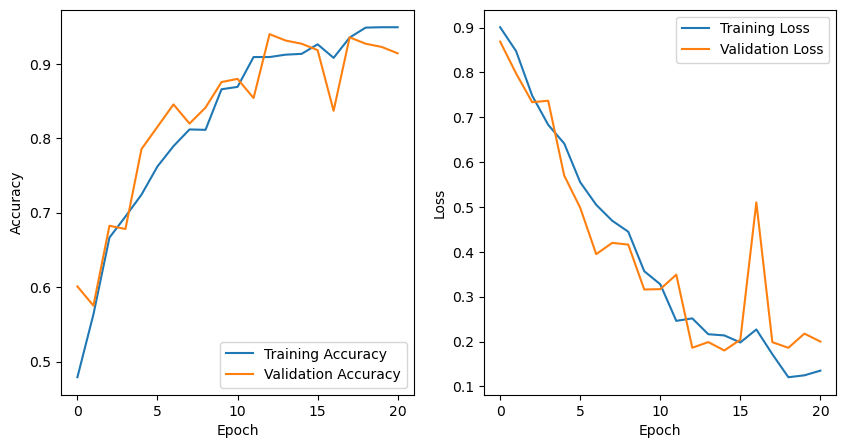

In [53]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [54]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

8/8 [==============================] - 1s 184ms/step - loss: 0.1070 - accuracy: 0.9620
Test loss: 0.1070103794336319 / Test accuracy: 0.9620253443717957


8/8 [==============================] - 1s 82ms/step
Accuracy: 0.4430379746835443


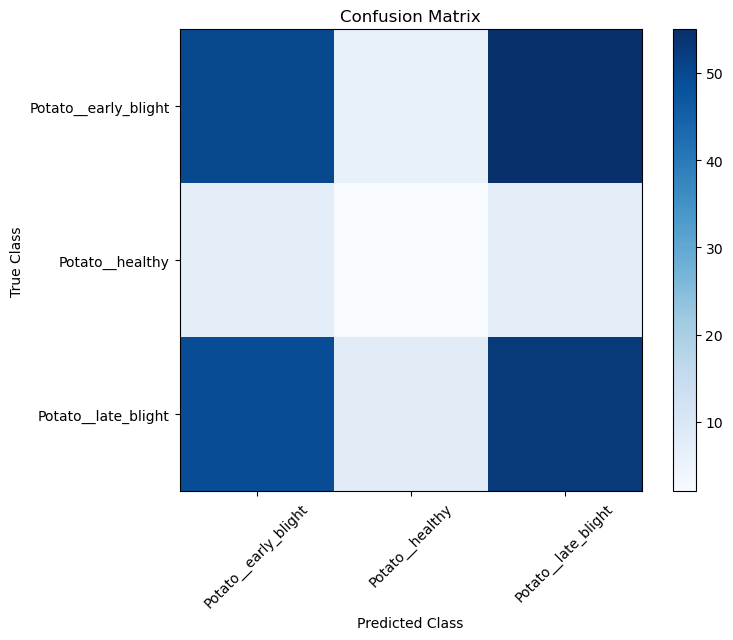

Classification Report:
                      precision    recall  f1-score   support

Potato__early_blight       0.47      0.45      0.46       111
     Potato__healthy       0.12      0.12      0.12        16
 Potato__late_blight       0.46      0.48      0.47       110

            accuracy                           0.44       237
           macro avg       0.35      0.35      0.35       237
        weighted avg       0.44      0.44      0.44       237

8/8 [==============================] - 1s 77ms/step - loss: 0.1070 - accuracy: 0.9620
Test loss: 0.10701039433479309 / Test accuracy: 0.9620253443717957


In [59]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = model.predict(testing_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = testing_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate accuracy
accuracy = np.trace(cm) / float(np.sum(cm))
print("Accuracy:", accuracy)

# Display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(class_count)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Other Metrics
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Display classification report
print("Classification Report:")
print(report)

score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [31]:
model.save('kentang-final.h5')